# STEP 3 Audio Preparation and Model


In [1]:
import os
import pandas as pd
import numpy as np
import librosa
import soundfile as sf
from tqdm.notebook import tqdm

In [2]:
#Global parameters
language_dic = {"es" : "Spanish" , "pt": "Portuguese"}
analysis_window_length = 0.01  # 10 ms in seconds
language_mp3_path = "/language_detector/languages"

In [3]:
# number of repeats defined by minimum duration: ceil(10 seconds / min duration)
min_clip = 0.10115625
x_seconds = 5
num_reps = int(np.ceil(x_seconds / min_clip))
def repeat_audio_x_seconds(track, dur, num_repeats=10, fs=16000):
    num_samples_xs = int(fs * dur)
    track = np.concatenate([track]*num_repeats, axis=0)
    track = track[0:num_samples_xs]
    return track

In [4]:
def processing_audio(language_mp3_path, analysis_window_length, language_dic):
    """
    This function samples mp3 files, analyzes the dataset content, and builds a dictionary of features.
    """
    data = {"filename": [], "language": [], "mfccs": []}  # Initialize data dictionary here
   
    language_list = os.listdir(language_mp3_path)

    for language in language_list:
        language_path = os.path.join(language_mp3_path, language)

        if language not in language_dic:
            print(f"Skipping language {language} because it is not in language_dic")
            continue

        language_name = language_dic.get(language, "Unknown language!")

        clips_path = os.path.join(language_path, "clips")
        # Check if the clips directory exists
        if not os.path.isdir(clips_path):
            print(f"No 'clips' directory found in {language_path}")
            continue

        # get a list of all files in the folder
        mp3_list = os.listdir(clips_path)
        mp3_list = mp3_list[:15000]

        # looping through all mp3s in one language
        for mp3 in tqdm(mp3_list):
            # adding the filename as key
            data["filename"].append(mp3)
            # adding the label/language
            data["language"].append(language_name)
            # adding the clip
            audio_path = os.path.join(clips_path, mp3)
            audio_samples, fs = sf.read(audio_path)
            audio_samples = repeat_audio_x_seconds(audio_samples, x_seconds, num_repeats=num_reps, fs=fs)
            y = audio_samples
            sr = fs
            hop_length = int(analysis_window_length * sr)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=128, hop_length=hop_length)
            mfccs_scaled_features = np.mean(mfcc.T,axis=0)
            data["mfccs"].append(mfccs_scaled_features)

    return data


In [5]:
data = processing_audio(language_mp3_path, analysis_window_length, language_dic)

Skipping language it because it is not in language_dic
Skipping language ja because it is not in language_dic


  0%|          | 0/15000 [00:00<?, ?it/s]

Skipping language ro because it is not in language_dic
Skipping language fr because it is not in language_dic
Skipping language de because it is not in language_dic


  0%|          | 0/15000 [00:00<?, ?it/s]

Skipping language ca because it is not in language_dic


In [25]:
# Printing shape to confirm the input to the model 
df = pd.DataFrame(data)
print(df.head())
df.mfccs[50].shape

                       filename    language  \
0  common_voice_pt_37043332.mp3  Portuguese   
1  common_voice_pt_36633365.mp3  Portuguese   
2  common_voice_pt_36729579.mp3  Portuguese   
3  common_voice_pt_37247144.mp3  Portuguese   
4  common_voice_pt_36968505.mp3  Portuguese   

                                               mfccs  
0  [-539.5114839579494, 114.6822012595508, 22.181...  
1  [-405.3097416482386, 98.18068976512295, 2.9863...  
2  [-440.3899018615477, 118.3226215678037, 28.304...  
3  [-586.7340736369752, 109.71068537734304, 9.510...  
4  [-555.2675637959123, 178.62233650724764, 6.843...  


(128,)

In [26]:
#Check-point to see if all data was correctly loaded
print(f'The number of files loaded is: {len(df["filename"])}, in {df["language"].nunique()} languages')

The number of files loaded is: 30000, in 2 languages


In [27]:
X=np.array(df['mfccs'].tolist())
y=np.array(df['language'].tolist())

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [29]:
# using the train test split function
X_train, X_test, y_train, y_test = train_test_split(X,y ,
                                                    random_state=42,
                                                    train_size=0.8)

In [30]:
#Checking point
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(24000, 128) (6000, 128) (24000, 2) (6000, 2)


Model Creation

In [31]:
import tensorflow as tf
import visualkeras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [32]:
### No of classes
num_labels=y.shape[1]

In [33]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(128,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               12900     
                                                                 
 activation_4 (Activation)   (None, 100)               0         
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 200)               20200     
                                                                 
 activation_5 (Activation)   (None, 200)               0         
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_6 (Dense)             (None, 100)              

In [35]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [36]:
## Training model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5',
                               verbose=1, save_best_only=True)
start = datetime.now()

history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
721/750 [===========================>..] - ETA: 0s - loss: 2.2893 - accuracy: 0.6961
Epoch 1: val_loss improved from inf to 0.37199, saving model to saved_models/audio_classification.hdf5
750/750 [==============================] - 2s 2ms/step - loss: 2.2171 - accuracy: 0.7005 - val_loss: 0.3720 - val_accuracy: 0.8732
Epoch 2/100
718/750 [===========================>..] - ETA: 0s - loss: 0.3344 - accuracy: 0.8572
Epoch 2: val_loss improved from 0.37199 to 0.26456, saving model to saved_models/audio_classification.hdf5
750/750 [==============================] - 1s 1ms/step - loss: 0.3329 - accuracy: 0.8577 - val_loss: 0.2646 - val_accuracy: 0.8935
Epoch 3/100
718/750 [===========================>..] - ETA: 0s - loss: 0.2665 - accuracy: 0.8864
Epoch 3: val_loss improved from 0.26456 to 0.22746, saving model to saved_models/audio_classification.hdf5
750/750 [==============================] - 1s 1ms/step - loss: 0.2658 - accuracy: 0.8870 - val_loss: 0.2275 - val_accuracy: 0.9083

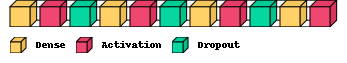

In [37]:
visualkeras.layered_view(model,legend=True, draw_volume=True)

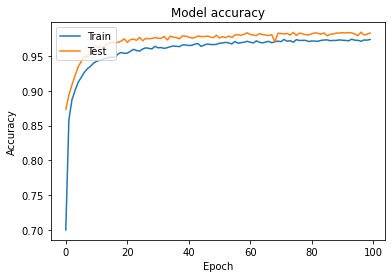

In [38]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

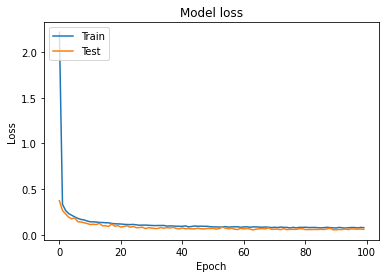

In [39]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

In [40]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.9828333258628845


In [41]:
y_pred = model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

188/188 [==============================] - 0s 796us/step


In [42]:
from sklearn.metrics import classification_report
target_names = sorted(df.language.unique())
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  Portuguese       0.98      0.99      0.98      3048
     Spanish       0.99      0.98      0.98      2952

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000



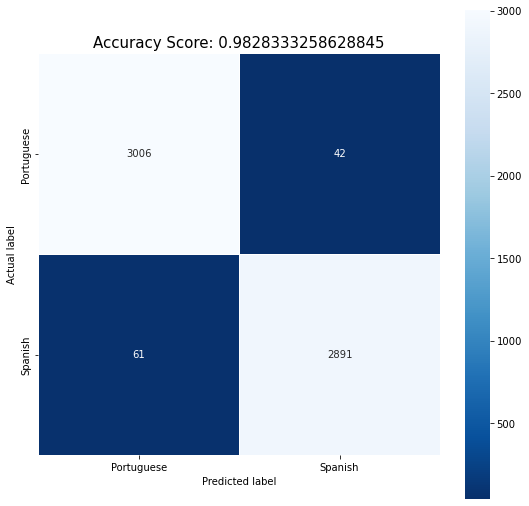

In [43]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Plotting the results:
plt.figure(figsize=(9,9))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r', xticklabels=target_names, yticklabels=target_names);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(test_accuracy[1])
plt.title(all_sample_title, size = 15);